In [1]:
%load_ext line_profiler
import gc
import concurrent.futures
from typing import Iterable

import numpy as np

from KeywordSearch import loader, indexing, utils, kwsearch, cloud_index
from KeywordSearch.loader import stemmer, stopwords_set
from KeywordSearch.kwsearch import token_index_dict, lookup_table

Please ignore the syntax warnings as small integers in CPython are singletons
Using `is` instead of `=` for comparison in performance-critical code is acceptable


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\10022\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


All languages: ['afrikaans', 'arabic', 'breton', 'bulgarian', 'catalan', 'chinese', 'czech', 'danish', 'dutch', 'english', 'esperanto', 'estonian', 'finnish', 'french', 'galician', 'german', 'greek', 'hebrew', 'hungarian', 'icelandic', 'interlingua ', 'inuktitut', 'irish', 'italian', 'japanese', 'korean', 'latin', 'lithuanian', 'maori', 'norwegian', 'occitan ', 'persian', 'polish', 'portuguese', 'romanian', 'russian', 'sanskrit', 'serbian', 'slovenian', 'spanish', 'swedish', 'tagalog', 'telugu', 'tibetan', 'welsh', 'western frisian', 'yiddish']


In [2]:
loader.category_dict.keys()

dict_keys(['10', '100', '101', '102', '103', '105', '106', '109', '11', '110', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '17', '18', '181', '19', '195', '196', '197', '198', '199', '20', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '22', '220', '221', '222', '223', '224', '226', '227', '228', '229', '23', '230', '231', '232', '234', '235', '236', '237', '239', '24', '240', '241', '244', '245', '246', '247', '248', '249', '25', '250', '252', '253', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '27', '270', '271', '272', '273', '274', '2

In [3]:
from google.cloud import firestore
from google.cloud.firestore_v1.field_path import FieldPath
db = firestore.Client(project="moonlit-oven-412316")
index_api = db.collection("index")
c = cloud_index.CloudIndex(index_api)

In [4]:
docIds = kwsearch.bool_search("idyllic  AND Fright AND Styrian AND \"Upon a paper attached to the Narrative\"", c, ["english"], [], debug=True)

res_json = {"books": [{"id": "PG" + str(docId), "title": loader.metadata[docId][2], 
                        "author": loader.metadata[docId][3], "subject": ", ".join(loader.metadata[docId][1]), 
                        "bookshelf": "bookshelf test", "language": ", ".join(loader.metadata[docId][0])} 
                        for docId in docIds]}
res_json

['idyllic  AND Fright AND Styrian AND "Upon a paper attached to the Narrative"']
['upon', 'paper', 'attach', 'narrat']


c:\Users\10022\anaconda3\Lib\site-packages\google\cloud\firestore_v1\base_collection.py:295: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


{'books': [{'id': 'PG10007',
   'title': 'Carmilla',
   'author': 'Le Fanu, Joseph Sheridan',
   'subject': '',
   'bookshelf': 'bookshelf test',
   'language': 'english'}]}

In [5]:
sum(len(doc.accessed_slice) + 1 for doc in c.cache.values())

45

In [6]:
c.gc()

In [7]:
docIds = kwsearch.bool_search("Once upon a time", c, ["english"], [], debug=True)

res_json = {"books": [{"id": "PG" + str(docId), "title": loader.metadata[docId][2], 
                        "author": loader.metadata[docId][3], "subject": ", ".join(loader.metadata[docId][1]), 
                        "bookshelf": "bookshelf test", "language": ", ".join(loader.metadata[docId][0])} 
                        for docId in docIds]}
res_json

['upon', 'time']


{'books': [{'id': 'PG11',
   'title': "Alice's Adventures in Wonderland",
   'author': 'Carroll, Lewis',
   'subject': '',
   'bookshelf': 'bookshelf test',
   'language': 'english'},
  {'id': 'PG34',
   'title': 'Zen and the Art of the Internet',
   'author': 'Kehoe, Brendan P.',
   'subject': 'internet',
   'bookshelf': 'bookshelf test',
   'language': 'english'},
  {'id': 'PG38',
   'title': 'The Jargon File, Version 2.9.10, 01 Jul 1992',
   'author': '',
   'subject': '',
   'bookshelf': 'bookshelf test',
   'language': 'english'},
  {'id': 'PG67',
   'title': 'The Black Experience in America',
   'author': 'Coombs, Norman',
   'subject': '',
   'bookshelf': 'bookshelf test',
   'language': 'english'},
  {'id': 'PG79',
   'title': 'Terminal Compromise',
   'author': 'Schwartau, Winn',
   'subject': '',
   'bookshelf': 'bookshelf test',
   'language': 'english'},
  {'id': 'PG89',
   'title': 'North American Free Trade Agreement, 1992 Oct. 7 Tariff Phasing Descriptions',
   'author':

In [8]:
docIds = kwsearch.bool_search("idyllic  AND Fright AND Styrian AND \"Upon a paper attached to the Narrative\"", c, ["english"], [], debug=True)

res_json = {"books": [{"id": "PG" + str(docId), "title": loader.metadata[docId][2], 
                        "author": loader.metadata[docId][3], "subject": ", ".join(loader.metadata[docId][1]), 
                        "bookshelf": "bookshelf test", "language": ", ".join(loader.metadata[docId][0])} 
                        for docId in docIds]}
res_json

['idyllic  AND Fright AND Styrian AND "Upon a paper attached to the Narrative"']
['upon', 'paper', 'attach', 'narrat']


{'books': [{'id': 'PG10007',
   'title': 'Carmilla',
   'author': 'Le Fanu, Joseph Sheridan',
   'subject': '',
   'bookshelf': 'bookshelf test',
   'language': 'english'}]}

In [11]:
docIds = sorted(kwsearch.adv_search("arthur", "sherlock homes", languages=["english"], subjects=[]))
res_json = {"books": [{"id": "PG" + str(docId), "title": loader.metadata[docId][2], 
                        "author": loader.metadata[docId][3], "subject": ", ".join(loader.metadata[docId][1]), 
                        "bookshelf": "bookshelf test", "language": ", ".join(loader.metadata[docId][0])} 
                        for docId in docIds]}
res_json

{'books': [{'id': 'PG108',
   'title': 'The Return of Sherlock Holmes',
   'author': 'Doyle, Arthur Conan',
   'subject': '',
   'bookshelf': 'bookshelf test',
   'language': 'english'},
  {'id': 'PG221',
   'title': 'The Return of Sherlock Holmes',
   'author': 'Doyle, Arthur Conan',
   'subject': '',
   'bookshelf': 'bookshelf test',
   'language': 'english'},
  {'id': 'PG834',
   'title': 'The Memoirs of Sherlock Holmes',
   'author': 'Doyle, Arthur Conan',
   'subject': '',
   'bookshelf': 'bookshelf test',
   'language': 'english'},
  {'id': 'PG1661',
   'title': 'The Adventures of Sherlock Holmes',
   'author': 'Doyle, Arthur Conan',
   'subject': '',
   'bookshelf': 'bookshelf test',
   'language': 'english'},
  {'id': 'PG2350',
   'title': 'His Last Bow: An Epilogue of Sherlock Holmes',
   'author': 'Doyle, Arthur Conan',
   'subject': '',
   'bookshelf': 'bookshelf test',
   'language': 'english'},
  {'id': 'PG4594',
   'title': 'Home Lights and Shadows',
   'author': 'Arthur,

In [13]:
q = "\"good\" OR NOT great"
[w.strip() for w in kwsearch.regex_bool_op.split(q)]

['"good"', 'OR', '', 'NOT', 'great']

In [9]:
kwsearch.bool_search("fine AND (okay AND (good OR NOT great)) AND happy", c, ["english"], [], debug=True)

['fine AND ', 'okay AND (good OR NOT great)', ' AND', ' happy']
['okay AND ', 'good OR NOT great', None, '']


{38,
 101,
 162,
 240,
 480,
 514,
 542,
 817,
 822,
 1979,
 2481,
 2509,
 3008,
 4342,
 4343,
 5176,
 5875,
 7038,
 7190,
 7773,
 8086,
 9070,
 10127,
 10347,
 10419,
 11357,
 11523,
 11583,
 11800,
 12733,
 13841,
 14556,
 16104,
 16515,
 16921,
 17029,
 17138,
 17385,
 17866,
 17985,
 18139,
 18224,
 18361,
 18492,
 18602,
 18719,
 18753,
 18768,
 19145,
 19258,
 19471,
 19660,
 19726,
 20147,
 20212,
 20519,
 20727,
 20796,
 20856,
 20857,
 20898,
 20988,
 21092,
 21510,
 21988,
 22239,
 22332,
 22338,
 22342,
 22682,
 22754,
 22767,
 22867,
 23162,
 23164,
 23301,
 23335,
 23535,
 23882,
 24290,
 24436,
 24865,
 24977,
 25024,
 25035,
 25051,
 25067,
 25730,
 25739,
 25741,
 25743,
 26168,
 26772,
 26941,
 27089,
 27211,
 27392,
 27444,
 27526,
 27631,
 27756,
 28215,
 28488,
 28813,
 28849,
 28883,
 29133,
 29193,
 29204,
 29240,
 29488,
 29614,
 29620,
 29749,
 29762,
 29768,
 29910,
 29919,
 30124,
 30305,
 30329,
 30378,
 30401,
 30532,
 30539,
 30679,
 30885,
 30901,
 30932,


In [3]:
#index = loader.load_merged_index(max_workers=8, dummy=False)

In [4]:
phrase_query = [w for w in "Upon a paper attached to the Narrative".casefold().split(' ') if w not in loader.stopwords_set]
# kwsearch.phrase_search(phrase_query, index, True)

In [5]:
# utils.construct_bool_table(index, loader.all_tokens, loader.processed_books)

In [10]:
import scipy.sparse
m = scipy.sparse.dok_array((5,5), dtype=np.bool_)

In [11]:
m[1,2]=True

In [12]:
m

<5x5 sparse array of type '<class 'numpy.bool_'>'
	with 1 stored elements in Dictionary Of Keys format>

In [14]:
del m[1,2]

In [15]:
m

<5x5 sparse array of type '<class 'numpy.bool_'>'
	with 0 stored elements in Dictionary Of Keys format>

In [7]:
phrase_query = [w for w in "Upon a paper attached to the Narrative".casefold().split(' ') if w not in loader.stopwords_set]
%lprun -f phrase_search_cloud result = phrase_search_cloud(phrase_query, c, max_dist=3)
c.gc()

c:\Users\10022\anaconda3\Lib\site-packages\google\cloud\firestore_v1\base_collection.py:295: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


Timer unit: 1e-07 s

Total time: 6.34344 s
File: C:\Users\10022\AppData\Local\Temp\ipykernel_16080\2214331718.py
Function: phrase_search_cloud at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def phrase_search_cloud(words: list[str], index: Iterable[dict] | cloud_index.CloudIndex, max_dist: int=1, debug: bool=False):
     2         1          4.0      4.0      0.0      search_result = []
     3         1          3.0      3.0      0.0      if debug:
     4                                                   print(stemmer.stemWords(words))
     5         1          6.0      6.0      0.0      word_ids = (token_index_dict[stemmer.stemWord(word)] for word in words)
     6         1        345.0    345.0      0.0      word_ids = tuple({word_id for word_id in word_ids if word_id})
     7         1          5.0      5.0      0.0      all_ids = list(word_ids)
     8         1       4531.0   4531.0      0.0      intersectio

In [9]:
%lprun -f phrase_search_cloud result = phrase_search_cloud(phrase_query, c, max_dist=3)

Timer unit: 1e-07 s

Total time: 0.371715 s
File: C:\Users\10022\AppData\Local\Temp\ipykernel_16080\2214331718.py
Function: phrase_search_cloud at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def phrase_search_cloud(words: list[str], index: Iterable[dict] | cloud_index.CloudIndex, max_dist: int=1, debug: bool=False):
     2         1          3.0      3.0      0.0      search_result = []
     3         1          7.0      7.0      0.0      if debug:
     4                                                   print(stemmer.stemWords(words))
     5         1          6.0      6.0      0.0      word_ids = (token_index_dict[stemmer.stemWord(word)] for word in words)
     6         1        166.0    166.0      0.0      word_ids = tuple({word_id for word_id in word_ids if word_id})
     7         1          6.0      6.0      0.0      all_ids = list(word_ids)
     8         1       3360.0   3360.0      0.1      intersecti

In [18]:
f1 = tmp[0]
s1 = tmp[1]

In [22]:
s1

array([   63,   225,   553,   625,   689,  1291,  1328,  1470,  1473,
        1640,  1792,  1983,  2282,  2346,  2709,  2778,  2813,  2942,
        3018,  3047,  3407,  3460,  3464,  3532,  3629,  4193,  4235,
        4484,  4491,  5238,  5275,  5837,  5867,  6519,  6550,  6784,
        6871,  7267,  7423,  7947,  7965,  8249,  8276,  8776,  8949,
        9048,  9194,  9558,  9688,  9896,  9958, 10021, 10390, 10721,
       11169, 11192, 11226, 11345, 11353, 11514, 11548, 11632, 11909,
       12125, 12263, 12347, 12369, 12726, 12766], dtype=uint64)

In [42]:
np.searchsorted([1,2,5,7], [3,4,9])-1

array([1, 1, 3], dtype=int64)

In [38]:
f1[np.searchsorted(f1, s1)]-1 == s1

array([ True, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [11]:
di = index_api.document("14071817").get().to_dict()

In [6]:
d0 = index_api.document("14071817_0").get().to_dict()

In [9]:
d1 = index_api.document("14071817_1").get().to_dict()

In [10]:
3456 in d1['h']

True

In [14]:
cc = c[14071817]

In [15]:
cc.known_keys

{2: 0, 12755: 1, 28538: 2, 41750: 3, 54910: 4, 71090: 5}

In [13]:
np.searchsorted(di['h'], 3456)

2

In [12]:
di['h']

[1,
 1675,
 3498,
 5160,
 6942,
 9334,
 11692,
 13960,
 16288,
 18997,
 21652,
 24896,
 28148,
 31099,
 33953,
 36156,
 38656,
 40654,
 42661,
 44851,
 47212,
 49605,
 52177,
 54772,
 57241,
 59752,
 62890,
 66415,
 69490,
 72106]

In [2]:
import json

import numpy as np
from tqdm.notebook import tqdm

with open("index_json/2945_merged.json", 'r') as f:
    x = json.load(f)

In [10]:
size = [len(json.dumps(token_dict, skipkeys=True, ensure_ascii=True, check_circular=False, indent=None,
                separators=(',', ':'))) for token_dict in tqdm(x, total=len(x))]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [12]:
max(size) / 1024 / 1024

47.34448719024658

In [13]:
np.argmax(size)

17

In [16]:
loader.all_tokens[2945*5000 + 17]

'would'

In [42]:
2945*5000 + 17

14725017

In [34]:
z = json.dumps(x[12], skipkeys=True, ensure_ascii=True, check_circular=False, indent=None,
                separators=(',', ':'))

In [35]:
print(z[:100])

{"44292":[28893],"44833":[111501]}


In [24]:
subsize = [len(json.dumps(token_dict, skipkeys=True, ensure_ascii=True, check_circular=False, indent=None,
                separators=(',', ':'))) for token_dict in tqdm(x[17].values(), total=len(x[17]))]

  0%|          | 0/55748 [00:00<?, ?it/s]

In [4]:
x = c[549513]
x

In [5]:
x[31552]

array([    395,     455,    6574, ..., 1449061, 1449440, 1450588],
      dtype=uint64)

In [8]:
31552 in x

True

In [52]:
import json

SIZE_LIMIT = (1024 * 512) - 2
entry_sep = ",\""

def dummy_upload(content: str, fname: str, dir_: str="test/"):
    with open(dir_ + fname, 'w', encoding="ascii") as f:
        f.write('{' + content + '}')

def upload_firestore(content: str, fname: str):
    # print(f"Uploading {fname}")
    index_api.document(fname).set(json.loads(f"{{{content}}}"))

def upload_token_json(token_dict: dict[str, list[int]], token_id: int):
    content = json.dumps(token_dict, skipkeys=True, ensure_ascii=True, check_circular=False, indent=None, separators=(',', ':'))
    slice_id = 1
    slice_size = -1
    current_slice = []
    slices = content[2:-1].split(entry_sep) # {int_id}":[{occurences}]
    slice_lookup_table = dict()
    slice_lookup_table[slice_id] = []
    while slices:
        next_size = len(slices[-1])
        size_after_addition = slice_size + 2 + next_size
        if size_after_addition > SIZE_LIMIT:
            return upload_firestore('"' + entry_sep.join(current_slice), f"{token_id}_{slice_id}")
            slice_id += 1
            slice_size = -1
            current_slice = []
            slice_lookup_table[slice_id] = []
        else:
            slice_size = size_after_addition
            addition = slices.pop()
            current_slice.append(addition)
            slice_lookup_table[slice_id].append(int(addition.split('"')[0]))
    if current_slice:
        upload_firestore('"' + entry_sep.join(current_slice), f"{token_id}_{slice_id}")
    lookup_str = json.dumps(slice_lookup_table, skipkeys=True, ensure_ascii=True, check_circular=False, indent=None, separators=(',', ':'))
    upload_firestore(lookup_str[1:-1], f"{token_id}")


In [54]:
dd = upload_token_json(x[17], 2945*5000 + 17)

In [55]:
dd.keys()

dict_keys(['61537', '61536', '61535', '61534', '61533', '61530', '61529', '61526', '61523', '61522', '61521', '61520', '61519', '61518', '61517', '61515', '61514', '61513', '61512', '61511', '61510', '61509', '61507', '61506', '61505', '61504', '61502', '61499', '61498', '61497', '61496', '61495', '61494', '61492', '61487', '61486', '61484', '61483', '61482', '61481', '61478', '61477', '61476', '61475', '61474', '61473', '61471', '61470', '61469', '61468', '61467', '61466', '61464', '61462', '61459', '61457', '61456', '61455', '61454', '61453', '61451', '61450', '61449', '61447', '61445', '61444', '61443', '61442', '61441', '61440', '61439', '61437', '61436', '61435', '61434', '61433', '61432', '61430', '61429', '61428', '61427', '61426', '61423', '61422', '61421', '61420', '61419', '61417', '61416', '61414', '61412', '61410', '61407', '61406', '61405', '61402', '61401', '61400', '61398', '61397', '61396', '61395', '61394', '61393', '61391', '61389', '61388', '61386', '61385', '61384',

In [57]:
index_api.document("TEST").set({"field1":["[1,2,3]", "[2,3,4]"], "field2":[1,2]})

update_time {
  seconds: 1709411077
  nanos: 134687000
}

In [58]:
index_api.document("TEST").get().to_dict()

{'field1': ['[1,2,3]', '[2,3,4]'], 'field2': [1, 2]}

In [44]:
f"{{{17}}}"

'{17}'

In [26]:
max(subsize)/1024/1024

0.05648994445800781

In [17]:
from nltk.corpus import stopwords
ss = set(stopwords.words('english'))

In [22]:
"would" in ss

False

In [7]:
x = list(index_api.list_documents())

In [26]:
y = index_api.document('121665').get()

In [27]:
%timeit y.to_dict()["appears_in"]

2.14 µs ± 50.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [28]:
%timeit y.get("appears_in")

2.6 µs ± 69.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [23]:
y = index_api.document('121665').get()

In [72]:
import requests
requests.post("https://ttds-gutenberg-fvyohsgcaq-ez.a.run.app/boolean", json={"query":"fine AND (okay AND (good OR NOT great)) AND happy"}).text

'{"docIds":[{"id":"PG40961"},{"id":"PG65538"},{"id":"PG51203"},{"id":"PG51205"},{"id":"PG51210"},{"id":"PG59404"},{"id":"PG49165"},{"id":"PG71692"},{"id":"PG34832"},{"id":"PG63506"},{"id":"PG63516"},{"id":"PG32805"},{"id":"PG38"},{"id":"PG20519"},{"id":"PG18492"},{"id":"PG71744"},{"id":"PG71754"},{"id":"PG69708"},{"id":"PG69709"},{"id":"PG69722"},{"id":"PG101"},{"id":"PG41062"},{"id":"PG51305"},{"id":"PG10347"},{"id":"PG32880"},{"id":"PG55415"},{"id":"PG32889"},{"id":"PG71806"},{"id":"PG69762"},{"id":"PG16515"},{"id":"PG71814"},{"id":"PG28813"},{"id":"PG71821"},{"id":"PG51344"},{"id":"PG26772"},{"id":"PG45208"},{"id":"PG22682"},{"id":"PG63645"},{"id":"PG34975"},{"id":"PG63648"},{"id":"PG51361"},{"id":"PG162"},{"id":"PG30885"},{"id":"PG57509"},{"id":"PG18602"},{"id":"PG28849"},{"id":"PG10419"},{"id":"PG30901"},{"id":"PG37060"},{"id":"PG51396"},{"id":"PG53448"},{"id":"PG61645"},{"id":"PG63696"},{"id":"PG28883"},{"id":"PG30932"},{"id":"PG39125"},{"id":"PG63703"},{"id":"PG59609"},{"id":"PG

In [71]:
requests.post("https://ttds-gutenberg-fvyohsgcaq-ez.a.run.app/boolean", json={"query":"Hi Hello How's it going?"}).text

'{"docIds":[]}\n'

In [49]:
index_api.document('1test').get().to_dict()

In [69]:
c = cloud_index.CloudIndex(index_api)

In [70]:
kwsearch.bool_search("Hi Hello How's it going?", c)

AttributeError: 'NoneType' object has no attribute 'items'

In [25]:
y.get("appears_in")[0]

'200: 315532 316317 316320 316322 316330 352116 352121 452587'

In [45]:
class CloudIndexDict(dict):
    def __init__(self, index_api):
        self.index_api = index_api
        super().__init__(self)
    def __missing__(self, key):
        doc = self.index_api.document(str(key)).get()
        self[key] = {int(k) : v for k, v in doc.to_dict().items()}
        return self[key]

class CloudIndex:
    def __init__(self, db) -> None:
        self.index_api = db.collection("index")
        self.cache = CloudIndexDict(self.index_api)
    def __getitem__(self, i: int|str):
        return self.cache[i]

c = CloudIndex(db)

In [47]:
c["1test"][123]

AttributeError: 'NoneType' object has no attribute 'items'

In [40]:
c.cache.clear()

In [41]:
c["test"][123]

AttributeError: 'NoneType' object has no attribute 'items'

In [13]:
import numpy as np
from tqdm.notebook import trange

In [14]:
length = np.array([kwsearch.lookup_table.getrow(i).indices.shape[0] for i in trange(kwsearch.lookup_table.shape[0])], dtype=np.uint32)

  0%|          | 0/14930836 [00:00<?, ?it/s]

In [24]:
import matplotlib.pyplot as plt

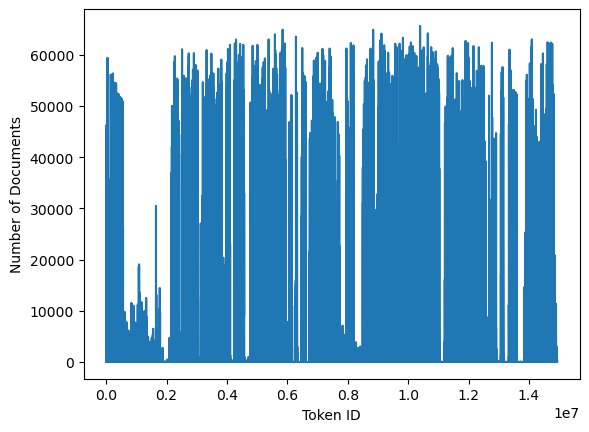

In [29]:
plt.plot(np.arange(len(length)), length)
plt.xlabel("Token ID")
plt.ylabel("Number of Documents")
plt.show()

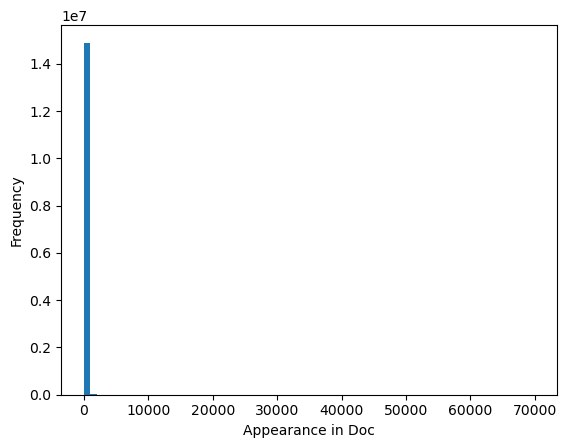

In [52]:
plt.cla()
n, bins, _ = plt.hist(length, bins=np.arange(0, 70001, 1000))
plt.ylabel("Frequency")
plt.xlabel("Appearance in Doc")
plt.show()

In [53]:
for i, count in enumerate(n):
    print(f"{int(bins[i]):05d}-{int(bins[i+1]):05d} : {int(count)}")

00000-01000 : 14895103
01000-02000 : 15513
02000-03000 : 5399
03000-04000 : 2544
04000-05000 : 1688
05000-06000 : 1251
06000-07000 : 964
07000-08000 : 787
08000-09000 : 676
09000-10000 : 497
10000-11000 : 471
11000-12000 : 426
12000-13000 : 395
13000-14000 : 302
14000-15000 : 256
15000-16000 : 248
16000-17000 : 215
17000-18000 : 211
18000-19000 : 185
19000-20000 : 185
20000-21000 : 149
21000-22000 : 165
22000-23000 : 138
23000-24000 : 151
24000-25000 : 146
25000-26000 : 126
26000-27000 : 109
27000-28000 : 113
28000-29000 : 104
29000-30000 : 121
30000-31000 : 108
31000-32000 : 116
32000-33000 : 93
33000-34000 : 89
34000-35000 : 108
35000-36000 : 94
36000-37000 : 78
37000-38000 : 97
38000-39000 : 85
39000-40000 : 77
40000-41000 : 101
41000-42000 : 79
42000-43000 : 93
43000-44000 : 74
44000-45000 : 63
45000-46000 : 65
46000-47000 : 81
47000-48000 : 61
48000-49000 : 58
49000-50000 : 65
50000-51000 : 63
51000-52000 : 66
52000-53000 : 49
53000-54000 : 37
54000-55000 : 54
55000-56000 : 38
560

In [1]:
sum(n[1:])

NameError: name 'n' is not defined

In [7]:
kwsearch.lookup_table.indices.shape

(357847382,)

In [8]:
kwsearch.lookup_table.shape

(14930836, 72535)

In [11]:
kwsearch.lookup_table.getrow(1).indices.shape

(8565,)

In [2]:
index = loader.load_merged_index(max_workers=8, dummy=True)

2987 segments to load


Merging segments: 100%|██████████| 2987/2987 [00:29<00:00, 99.58it/s] 



Garbage collection done
The index took 3 minutes  33 seconds to load
All done


In [3]:
assert len(index) == len(loader.all_tokens)

In [4]:
table = utils.construct_bool_table(index, all_tokens=loader.all_tokens, valid_books=loader.processed_books)

Constructing lookup table: 100%|██████████| 14930836/14930836 [15:56<00:00, 15604.60it/s]


In [5]:
table

<14930836x72535 sparse matrix of type '<class 'numpy.bool_'>'
	with 357847382 stored elements in Compressed Sparse Row format>

In [10]:
print(f"Lookup table size: {(table.data.nbytes + table.indices.nbytes + table.indptr.nbytes) / 1024 / 1024 / 1024:.2f} GB")

Lookup table size: 1.72 GB


In [2]:
part_size = 20000
num_books = len(loader.processed_books)
num_parts = num_books // part_size
if num_books % part_size:
    num_parts += 1
i = 0
continue_from = 2

In [3]:
with concurrent.futures.ProcessPoolExecutor(max_workers=8) as pool:
    for i in range(continue_from, num_parts):
        gc.collect()
        print(f"\nPart {i:02d}", flush=True)
        indexing.build_full_index(pool, offset=i*part_size, k=part_size, batch_size=500, index_type="inverted", prefix=f"part{i:02d}")


Part 02


Submitting jobs:   0%|          | 0/20000 [00:00<?, ?it/s]

Initialising...:   0%|          | 0/20000 [00:00<?, ?it/s]

0/20000 failures while building index


Dumping (pickle):   0%|          | 0/2987 [00:00<?, ?it/s]


Part 03


Submitting jobs:   0%|          | 0/10974 [00:00<?, ?it/s]

Initialising...:   0%|          | 0/10974 [00:00<?, ?it/s]

0/10974 failures while building index


Dumping (pickle):   0%|          | 0/2987 [00:00<?, ?it/s]

In [4]:
gc.collect()
indexing.merge_index()

2987 segments to merge
Finished merging parts for 2987 segments...
All done


In [2]:
utils.pickle_to_json()

2987 segments to load


Saving json segments:   0%|          | 0/2987 [00:00<?, ?it/s]

In [ ]:
import numpy as np
import scipy.sparse
from pympler.asizeof import asizeof

%load_ext line_profiler

In [3]:
%lprun -f indexing.build_full_index indexing.build_full_index(offset=i*part_size, k=part_size, batch_size=500, index_type="inverted", prefix=f"part{i:02d}")

Submitting jobs:   0%|          | 0/20000 [00:00<?, ?it/s]

Initialising...:   0%|          | 0/20000 [00:00<?, ?it/s]

0/20000 failures while building index


Timer unit: 1e-07 s

Total time: 8073.43 s
File: c:\Users\10022\Documents\GitHub\ttds-group-project\KeywordSearch\indexing.py
Function: build_full_index at line 39

Line #      Hits         Time  Per Hit   % Time  Line Contents
    39                                           def build_full_index(offset: int=0, k: int=-1, batch_size: int=50, index_type: str="inverted", prefix: str="", skip_pickle: bool=False) -> tuple[list, list]:
    40         1          6.0      6.0      0.0      assert index_type in ("bow", "inverted"), "index_type must be \"bow\" or \"inverted\""
    41                                           
    42         2        788.0    394.0      0.0      with open("processed_books.pkl", "rb") as f:
    43         1      21244.0  21244.0      0.0          processed_books = pickle.load(f)
    44         2       1320.0    660.0      0.0      with open("all_tokens.pkl", "rb") as f:
    45         1    9885855.0    1e+07      0.0          _, _, all_tokens = pickle.load(f)
   

In [2]:
loader.process_first_k_books(k=-1, batch_size=50)

70974 books to process


Initialising...:   0%|          | 0/70974 [00:00<?, ?it/s]

0/70974 pre-processing jobs failed:
- 


In [5]:
gc.collect()
index = loader.load_merged_index(save_merged=False)

2987 segments to load


  0%|          | 0/2987 [00:00<?, ?it/s]

  0%|          | 0/2987 [00:00<?, ?it/s]


Garbage collection done
The index took 55 seconds to load
All done


In [ ]:
from pympler.asizeof import asizeof

In [8]:
index[10]

{}

In [4]:
len(loader.all_tokens)

0

In [2]:
and_set = indexing.stemmer.stemWords(["fine", "okay", "happy"])
good = indexing.stemmer.stemWord("good")
not_great = indexing.stemmer.stemWord("great")
query = "fine AND (okay AND (good OR NOT great)) AND happy"
result, _ = kwsearch._bool_search(query, debug=True)
len(result)

['fine AND ', 'okay AND (good OR NOT great)', ' AND', ' happy']
['okay AND ', 'good OR NOT great', None, '']


513

In [3]:
from tqdm import tqdm

num_result = len(result)
for book_id in tqdm(result, total=num_result, desc=f"Validating {num_result} results"):
    with open(loader.token_dir + f"PG{book_id}_tokens.txt", 'r', encoding="UTF-8", errors="ignore") as f:
        tokens = set(indexing.stemmer.stemWords(f.read().splitlines()))
    assert all((term in tokens) for term in and_set) and ((good in tokens) or (not_great not in tokens))

Validating 513 results: 100%|██████████| 513/513 [00:14<00:00, 35.09it/s]


In [4]:
%lprun -f kwsearch.bool_search kwsearch.bool_search(query)

Timer unit: 1e-07 s

Total time: 0.0076213 s
File: c:\Users\10022\Documents\GitHub\ttds-group-project\KeywordSearch\kwsearch.py
Function: bool_search at line 49

Line #      Hits         Time  Per Hit   % Time  Line Contents
    49                                           def bool_search(query: str, debug: bool=False) -> set:
    50         2          6.0      3.0      0.0      if debug:
    51                                                   print(regex_bracket.split(query))
    52         2         68.0     34.0      0.1      tokens = (bool_search_atomic(token, debug) for token in regex_bracket.split(query) if token)
    53         2          8.0      4.0      0.0      is_not = is_and = is_or = False
    54         2      19306.0   9653.0     25.3      valid, (is_not, is_and, is_or) = next(tokens)
    55         6      50494.0   8415.7     66.3      for token_eval, (is_not_, is_and_, is_or_) in tokens:
    56         4         73.0     18.2      0.1          if isinstance(token_eva

In [7]:
phrase_query = "Upon a paper attached to the Narrative".casefold().split(' ')
kwsearch.phrase_search(phrase_query, index)

{10007, 37174}

In [8]:
%lprun -f kwsearch.phrase_search kwsearch.phrase_search(phrase_query, index)

Timer unit: 1e-07 s

Total time: 0.339141 s
File: c:\Users\10022\Documents\GitHub\ttds-group-project\KeywordSearch\kwsearch.py
Function: phrase_search at line 134

Line #      Hits         Time  Per Hit   % Time  Line Contents
   134                                           def phrase_search(words: list[str], index: list[dict] | tuple[dict], debug: bool=False):
   135         1          5.0      5.0      0.0      search_result = []
   136         1          2.0      2.0      0.0      if debug:
   137                                                   print([stemmer.stemWord(word) for word in words if word not in stopwords_set])
   138         1        214.0    214.0      0.0      word_ids = [token_index_dict[stemmer.stemWord(word)] for word in words if word not in stopwords_set]
   139         1         43.0     43.0      0.0      index_entries = [index[i] for i in word_ids]
   140         1         19.0     19.0      0.0      first = list(set(word_ids))
   141         1     170087.0 1

In [9]:
[kwsearch.stemmer.stemWord(word) for word in phrase_query if word not in indexing.stopwords_set]

['upon', 'paper', 'attach', 'narrat']

In [55]:
from KeywordSearch.kwsearch import stemmer, token_index_dict, lookup_table, book_index
from KeywordSearch.indexing import stopwords_set
import numpy as np

def phrase_search(words: list[str], debug: bool=False):
    search_result = []
    if debug:
        print([stemmer.stemWord(word) for word in words if word not in stopwords_set])
    word_ids = [token_index_dict[stemmer.stemWord(word)] for word in words if word not in stopwords_set]
    index_entries = [index[i] for i in word_ids]
    first = list(set(word_ids))
    intersection = lookup_table[first.pop(), :].indices
    for token_id in first:
        intersection = np.intersect1d(intersection, lookup_table[token_id, :].indices, assume_unique=True)
    del first, word_ids

    for docID in intersection:
        occurs = (entry[docID] for entry in index_entries) # use generator to avoid wasting time on non-matches
        first = next(occurs)
        second = next(occurs)
        matches: np.ndarray = second[first[np.searchsorted(first, second, side="right")-1] == second-1]
        del first, second

        if matches.shape[0]:
            for entry in occurs:
                i = np.searchsorted(matches, entry, side="right")
                i[i==0] = 1
                matches = entry[matches[i-1] == entry-1]
                if not matches.any():
                    break
            else:
                search_result.append(docID)
    return set(search_result)

In [56]:
phrase_search("Upon a paper attached to the Narrative".casefold().split(' '))

{10007, 37174}

In [ ]:
gc.collect()
from pympler.asizeof import asizeof
index_size = asizeof(index)
mb = 1024 * 1024
gb = mb * 1024
gb_size = index_size // gb
mb_size = round((index_size % gb) / mb)
print(f"{gb_size}GB" + f" {mb_size}MB" if mb_size else '')

44GB 370MB


In [ ]:
all_tokens = loader.load_token_vocab(k=-1)

In [ ]:
import pickle
with open("valid_books.pkl", "rb") as f:
    _, _, valid_books = pickle.load(f)

In [ ]:
len(all_tokens), len(index)

(5696023, 5696023)

In [ ]:
from typing import Iterable

import numpy as np
import scipy.sparse
try:
    from tqdm.notebook import tqdm
    USE_TQDM = True
except:
    USE_TQDM = False

def construct_bool_table(index: Iterable[dict], save_path: str|None=None):
    table = scipy.sparse.dok_matrix((len(all_tokens), max(valid_books) + 1), dtype=np.bool_)
    print(len(index), table.shape)
    length = len(all_tokens)
    tqdm_iter = enumerate(index[:length])
    if USE_TQDM:
        tqdm_iter = tqdm(tqdm_iter, total=length)
    for token_id, token_dict in tqdm_iter:
        if token_dict:
            table[token_id, tuple(token_dict.keys())] = True
    gc.collect()
    table = table.tocsr()
    if save_path is None:
        return table
    else:
        gc.collect()
        scipy.sparse.save_npz("lookup_table.npz", table, compressed=True)
        return table

In [ ]:
(table.data.nbytes + table.indptr.nbytes + table.indices.nbytes) // 1024 // 1024

1063

In [ ]:
dok_table: scipy.sparse.dok_matrix = table.todok()

In [ ]:
asizeof(dok_table) // 1024 // 1024

In [ ]:
asizeof(table) // 1024 // 1024

In [ ]:
scipy.sparse.save_npz("lookup_table_coo.npz", table.tocoo(), compressed=True)

In [ ]:
x = list(range(5696023))
y = []
index_size = len(x)
batch_size = 5000
batches = index_size // batch_size
for i in range(batches):
    start = i * batch_size
    end = min(start + batch_size, index_size)
    y.extend(x[start:end])

y.extend(x[end:])
x == y, end

(True, 5695000)

In [ ]:
with open("all_tokens_old.pkl", 'rb') as f:
    _, _, all_tokens_old = pickle.load(f)
len(all_tokens_old)

5696023

In [ ]:
# inverted_index_2, indexed_books_2 = indexing.build_full_index(offset=5000, k=5000, batch_size=-1, index_type="inverted", prefix="part02")
# import h5py
# def save_inv_index_HDF5(filename: str, index: list[dict], **kwargs):
#     with h5py.File(filename, 'w') as f:
#         for i, entry in enumerate(index):
#             group = f.create_group(str(i))
#             for book_id, occurrences in entry.items():
#                 group.create_dataset(str(book_id), data=occurrences, **kwargs)
# save_inv_index_HDF5("test.h5", inverted_index_1, chunks=True, compression="gzip")

In [ ]:
import pickle
import numpy as np

with open("index/inverted_113.pkl", "rb") as f:
    first = pickle.load(f)

In [ ]:
len(first)


In [ ]:
#bow_index, indexed_books = indexing.build_full_index(k=-1)

In [ ]:
import pickle
import numpy as np

with open("index.pkl", "rb") as f:
    bow_index = pickle.load(f)
# dummy_arr = np.array([], dtype=np.uint8)
# dummy = (0, dummy_arr, 0, dummy_arr)
# bow_index = tuple([dummy] + [pair if isinstance(pair, tuple) else dummy for pair in bow_index[1:]])
# with open("index.pkl", "wb") as f:
#     pickle.dump(bow_index, f)

with open("valid_books.pkl", "rb") as f:
    _, _, valid_books = pickle.load(f)

book_list = sorted(valid_books)

non_empty_books = []
non_empty_index = []
for book_id, book_bow in enumerate(bow_index):
    if book_bow:
        non_empty_books.append(book_id)
        non_empty_index.append(book_bow)

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import MatrixSimilarity, SparseMatrixSimilarity
import concurrent.futures

In [ ]:
# corpus = [utils.deltazip([vocab, counts], [vocab_delta, count_delta]) for vocab_delta, vocab, count_delta, counts in non_empty_index]
# tfidf_model = TfidfModel(corpus, smartirs='ntc')
# with open("tfidf_model.pkl", "wb") as f:
#     pickle.dump(tfidf_model, f)
with open("tfidf_model.pkl", "rb") as f:
    tfidf_model = pickle.load(f)

In [ ]:
dim = len(all_tokens) + 1
def cast2numpy(x):
    arr = np.zeros(dim, dtype=np.float16)
    for i, score in x:
        arr[i] = score
    return arr

In [ ]:
first = [tfidf_model[utils.deltazip([vocab, counts], [vocab_delta, count_delta])] for vocab_delta, vocab, count_delta, counts in non_empty_index]
# with open("tfidf_index.pkl", "rb") as f:
#     tmp = pickle.load(f)

In [ ]:
tfidf_model[[(0,1),(3,8)]]

In [ ]:
vocab_delta, vocab, count_delta, counts = non_empty_index[0]
cast2numpy(tfidf_model[utils.deltazip([vocab, counts], [vocab_delta, count_delta])]).mean()

In [ ]:
dim = len(all_tokens) + 1

In [ ]:
m1 = SparseMatrixSimilarity(first, num_best=10, num_features=dim)

In [ ]:
with open("tfidf_index.pkl", "wb") as f:
    pickle.dump(first, f)
with open("matrix.pkl", "wb") as f:
    pickle.dump(m1, f)

In [ ]:
asizeof.asizeof(first)/1024/1024/1024

In [ ]:
asizeof.asizeof(m1)/1024/1024/1024

In [ ]:
vocab_delta, vocab, count_delta, counts = non_empty_index[269]
next(utils.deltazip([vocab, counts], [vocab_delta, count_delta]))

In [ ]:
non_empty_index[269]

In [ ]:
tokens = [1, 3, 1, 9, 3, 5654]
vocab_list = sorted(set(tokens))
token_arr = np.array(tokens)
vocab, vocab_delta = utils.cast2intarr(vocab_list)
counts, count_delta = utils.cast2intarr([np.sum(token_arr == token) for token in vocab_list])
(vocab_delta, vocab, count_delta, counts, vocab_list, [(vocab == token-vocab_delta) for token in vocab_list])
vocab + vocab_delta, counts + count_delta

In [ ]:
book_path_template = loader.token_dir + "PG%d_tokens.txt"

def read_tokens(PG_id: int):
    with open(book_path_template %PG_id, encoding="UTF-8", errors="ignore") as f:
        return loader.stemmer.stemWords(f.read().splitlines())

In [ ]:


docs = []
docs_index = []
failed_jobs = 0
complete_counter = 0
with concurrent.futures.ThreadPoolExecutor() as pool:
    jobs = {
        pool.submit(
            read_tokens, book_id)
            : book_id for book_id in indexed_books
        }
    
    for job in concurrent.futures.as_completed(jobs):
        book_id = jobs[job]
        try:
            result = job.result()
            docs.append(result)
            docs_index.append(book_id)
        except Exception as e:
            # raise e
            failed_jobs.append(book_id)
        complete_counter += 1
        print(f"Finished fetching tokens in {complete_counter} books...", end="\r")
        
        print(f"\n{len(failed_jobs)}/{len(jobs)} token fetching jobs failed")

In [ ]:
dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]
del docs
tfidf = TfidfModel(corpus, smartirs='ntc')
tfidf_corpus = [tfidf[doc] for doc in corpus]
del corpus, tfidf
index = MatrixSimilarity(tfidf_corpus, num_features=len(dictionary))

In [ ]:
# import pickle
# with open("all_tokens.pkl", 'rb') as f:
#     k, offset, _all_tokens = pickle.load(f)
# with open("all_tokens.pkl", "wb") as f:
#     pickle.dump((k, offset, tuple(_all_tokens)), f)

In [ ]:
from pympler import asizeof
asizeof.asizeof(bow_index), asizeof.asizeof(index)

In [ ]:
415963552/1024/1024

In [ ]:
415971552/1024/1024

In [ ]:

mem_size_lst = asizeof.asizeof(all_tokens)
mem_size_tup = asizeof.asizeof(tuple(all_tokens))
mem_size_lst/1024/1024, mem_size_tup

In [ ]:
from math import log2
import numpy as np
log2(len(all_tokens))
x = np.array([1,2,3])
x.shape[0]

In [ ]:
#loader.build_full_index()

In [ ]:
import pickle

In [ ]:
with open("index.pkl", "rb") as f:
    index = pickle.load(f)

In [ ]:
from pympler import asizeof
mem_size = asizeof.asizeof(index)

In [ ]:
mem_size/1024/1024

In [ ]:
index[1]

In [ ]:
size = 0
print(len(index))
for i, token_eval in enumerate(index):
    for arr in token_eval.values():
        size += asizeof.asizeof(arr)
    print(i, end='\r')
size

In [ ]:
size/1024/1024

In [16]:
import re
import random

random.seed(2050808)
start, end = ord('a'), ord('z') + 1
r1, r2, r3, r4 = re.compile("\[.*?\]"), re.compile("\[.*\]"), re.compile(r"\b\w+\b"), re.compile(r"\W+")

tmp = [chr(random.randrange(start, end)) for _ in [0] * 1000000]
rand_pos = []
for _ in [0] * 100:
    x = random.randrange(0, 1000000)
    while x in rand_pos:
        x = random.randrange(0, 1000000)
    rand_pos.append(x)
rand_pos.sort()

while rand_pos:
    tmp[rand_pos.pop()] = ']'
    tmp[rand_pos.pop()] = '['

test_str = ''.join(tmp)
test_str2 = ''.join(''.join(chr(random.randrange(start, end)) for _ in [0] * random.randrange(5, 30)) + ' ' * random.randrange(1, 4) for _ in [0] * 100000)

del tmp, rand_pos

In [17]:
%timeit r1.findall(test_str)

2.27 ms ± 60.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
%timeit r2.findall(test_str)

260 µs ± 5.37 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [19]:
%timeit r1.findall(test_str)

2.26 ms ± 55 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
%timeit r3.findall(test_str2)

21.2 ms ± 305 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%timeit r4.split(test_str2)

29.4 ms ± 754 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%tim

In [29]:
import nltk
nltk.tokenize.sent_tokenize

<function nltk.tokenize.sent_tokenize(text, language='english')>